In [1]:
%matplotlib inline


# Various ICA experiments


Demonstrate some issues around ICA.


## Part 1 : load and inspect data
### load libraries

In [1]:
#import libraries
import numpy as np
from coroica import CoroICA, UwedgeICA
from matplotlib import pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from picard import Picard
from pylab import rcParams


So we see a hint we may be better with coroICA...this would make theoretical sense as maybe our ST segement in ECG provides some windows, and the same for passive exhalation. We also see our Picard didn't really shine in this case... let's look at what happends when we apply the algorithms to our kind of data. Unfortunately, we don't have the y, the true data... but we can still see if there are differences. WE can not use our closest lead to the heart as a sort of y, as it has both signals.

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import ipywidgets as widgets
import sys
sys.path.insert(0, '../resurfemg')

import helper_functions as hf
from tmsisdk_lite import Poly5Reader

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [3]:
# configure our data
from resurfemg.config import Config
config = Config()
root_emg_directory = config.get_directory('root_emg_directory')

In [4]:
# do not rerun this cell
big_data_list = []

In [5]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)

In [6]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

In [7]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen] 
print("The file you chose is:",file_chosen)

The file you chose is: C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5


In [8]:
data_emg = Poly5Reader(file_chosen)
data_samples= data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)
    converted_to_samples.append(i)

Reading file  C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5
	 Number of samples:  172576 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


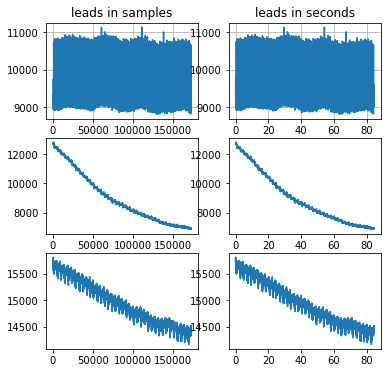

In [9]:
%matplotlib inline
# set up plotn
x = data_samples
fig, axis = plt.subplots(nrows = 3, ncols = 2, figsize=(6, 6))
#ax.set_ylim([-4, 4])
axis[0,0].grid(True)
axis[0,0].plot(x[0])
axis[0,0].set(title='leads in samples')
axis[1,0].plot(x[1])
axis[2,0].plot(x[2])
axis[0,1].set(title='leads in seconds')
axis[0,1].grid(True)
axis[0,1].plot(converted_to_seconds,x[0])
axis[1,1].plot(converted_to_seconds,x[1])
axis[2,1].plot(converted_to_seconds,x[2])

In [10]:
y_axis = widgets.Dropdown(
    options=["Samples","Seconds"],
    value='Samples',
    description="Select View Option",
    disabled=False,
)
display(y_axis)


Dropdown(description='Select View Option', options=('Samples', 'Seconds'), value='Samples')

In [11]:
time_view= y_axis.value
time_view

'Samples'

In [12]:
if time_view == 'Samples':
    int_slider1 = widgets.IntSlider(
        min=0, max=int(len(x[0])*0.89), step=1,
        description=' samples start'
    )
    int_slider2 = widgets.IntSlider(
        value=len(x[0]),
        min=0, max=int(len(x[0])*0.89), step=1,
        description='samples end cutoff'
    )
else:
    int_slider1 = widgets.IntSlider(
        #value=0.1,
        min=0, max= int(converted_to_seconds[-1])*0.89, step=1,
        description='seconds start'
    )
    int_slider2 = widgets.IntSlider(
        #value=converted_to_seconds[-1],
        min=0, max=int(converted_to_seconds[-1])*0.89, step= 1,
        description='seconds end cutoff'
    )
    
widgets.VBox(
    [

        int_slider1,
        int_slider2,

    ]
)



In [13]:
# # # # Here we can overwrite the values by hand, again you must pick values a bit inside
int_slider1.value = 5000
int_slider2.value = 70000

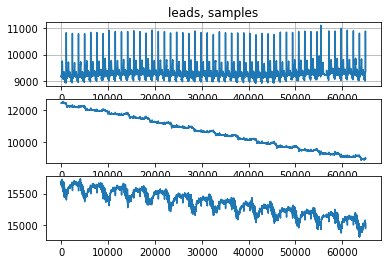

In [14]:
start = int_slider1.value
end= int_slider2.value
if time_view == 'Samples':
    # nox examine at a certain scale- from point a to b as samples
    x = data_samples
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(x[0][int(start):int(end)])
    ax_1.set(title='leads, samples')
    ax_2.plot(x[1][int(start):int(end)])
    ax_3.plot(x[2][int(start):int(end)])
    
if time_view == 'Seconds':
    # nox examine at a certain scale- from point a to b as samples
    x_for_secs = data_samples

    y = converted_to_seconds
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[0][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    ax_1.set(title='leads, seconds')
    ax_2.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[1][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    ax_3.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[2][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    

In [15]:

emg = hf.emg_bandpass_butter_sample(
        data_samples,
        5,
        450,
        2048,
        output='sos',
    )
print(np.max(emg[0][0:150000]),np.min(emg[0][0:150000]))
print(np.max(emg[1][0:150000]),np.min(emg[1][0:150000]))
print(np.max(emg[2][0:150000]),np.min(emg[2][0:150000]))

1486.8475113550787 -460.73702045264105
112.49964354832512 -73.78830787442581
144.69583466570043 -146.96137357220795


In [16]:
print("Lead 0 has", np.max(emg[0][0:150000])-np.min(emg[0][0:150000]), "variance in amplitude")
print("Lead 1 has", np.max(emg[1][0:150000])-np.min(emg[1][0:150000]), "variance in amplitude")
print("Lead 2 has", np.max(emg[2][0:150000])-np.min(emg[2][0:150000]), "variance in amplitude")

Lead 0 has 1947.5845318077197 variance in amplitude
Lead 1 has 186.28795142275095 variance in amplitude
Lead 2 has 291.6572082379084 variance in amplitude


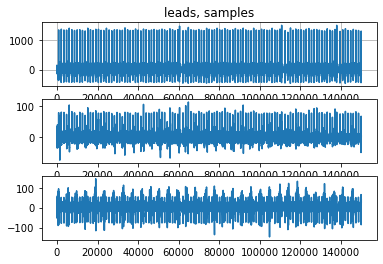

In [17]:
# graph part of it to examine
x = emg
fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
ax_1.grid(True)
ax_1.plot(x[0][0:150000])
ax_1.set(title='leads, samples')
ax_2.plot(x[1][0:150000])
ax_3.plot(x[2][0:150000])
    

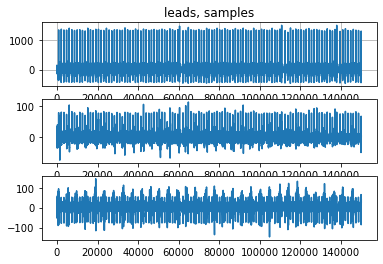

In [18]:
re_cut_file_data = hf.bad_end_cutter_for_samples(
        emg,
        percent_to_cut=3,
        tolerance_percent=5,
    )
X = re_cut_file_data
fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
ax_1.grid(True)
ax_1.plot(X[0][0:150000])
ax_1.set(title='leads, samples')
ax_2.plot(X[1][0:150000])
ax_3.plot(X[2][0:150000])

## A new function to pick out our compnent. 

And no it doesn't matter which ICA we use (although FastICA or Picard performs better here). The fundemanetal problem will still be there. Looking forward to your solutions. You can examine the various existing picker algorithms in helper_functions i.e. pick_more_peaks_array and pick_lowest_correlation_array


Fundamentally, you now need to label a lead as "most diaphragm-like" if you wast to use all components, and this is risky, but I await a more insightful solution.

In [72]:
data = re_cut_file_data

A = data

In [73]:
X = np.c_[data[0], data[1], data[2]]
B = X



In [54]:
ica = FastICA(n_components=3)
S = ica.fit_transform(X)

C =S
tu_ica = FastICA(n_components=2)
S2 = ica.fit_transform(X)
D = S2

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


In [55]:
C

array([[ 1.08068056e-03,  1.16482800e-03,  8.13383710e-04],
       [ 9.83482116e-04,  2.47608448e-04,  1.55621590e-03],
       [ 8.86906997e-04, -3.34110155e-04,  1.81463063e-03],
       ...,
       [-9.36007876e-04, -7.55039312e-05,  2.68426425e-04],
       [-9.20065905e-04, -1.27938199e-04,  2.19409046e-04],
       [-8.93071249e-04, -2.49906344e-04,  1.21912102e-04]])

In [29]:
# this is ICA 3 lead output
component_0 = S.T[0]
component_1 = S.T[1]
component_2 = S.T[2]

# this is ICA 2 lead output
tu_component_0 = S2.T[0]
tu_component_1 = S2.T[1]


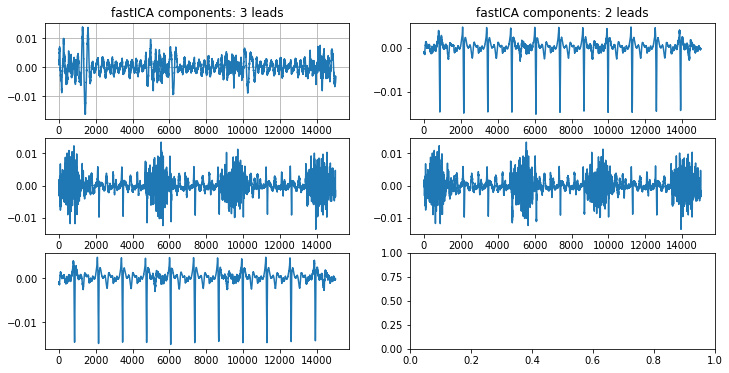

In [34]:
# this is ICA components graphed
fig, axis = plt.subplots(nrows = 3, ncols= 2, figsize=(12, 6))
axis[0,0].grid(True)
axis[0,0].plot(component_0[0:15000])
axis[0,0].set(title='fastICA components: 3 leads')
axis[1,0].plot(component_1[0:15000])
axis[2,0].plot(component_2[0:15000])
axis[0,1].plot(tu_component_0[0:15000])
axis[0,1].set(title='fastICA components: 2 leads')
axis[1,1].plot(tu_component_1[0:15000])

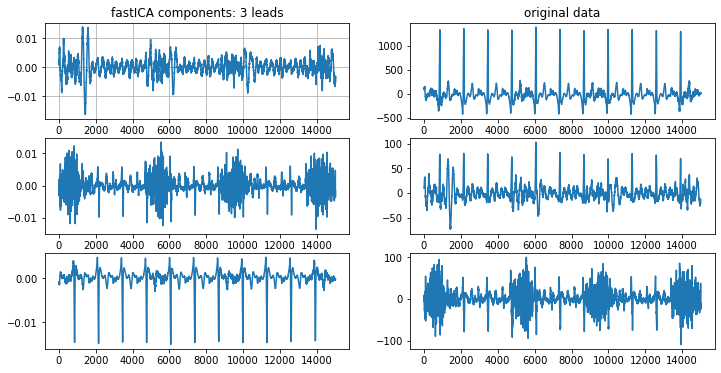

In [37]:
# this is ICA components graphed verus original leads
fig, axis = plt.subplots(nrows = 3, ncols= 2, figsize=(12, 6))
axis[0,0].grid(True)
axis[0,0].plot(component_0[0:15000])
axis[0,0].set(title='fastICA components: 3 leads')
axis[1,0].plot(component_1[0:15000])
axis[2,0].plot(component_2[0:15000])
axis[0,1].plot(data[0][0:15000])
axis[0,1].set(title='original data')
axis[1,1].plot(data[1][0:15000])
axis[2,1].plot(data[2][0:15000])

In [29]:
# for i in range(len(emg_files)):
#     list_of_numbers_strung.append(str(i))


# btn = widgets.Dropdown(
#     options=list_of_numbers_strung,
#     value='0',
#     description='Picked File:',
#     disabled=False,
# )
# display(btn)

In [30]:
# here is the zeroing of one lead
# make S-copy so it can not rereun from the top
S.T[lead_picked] = np.zeros(len(component_0))

NameError: name 'lead_picked' is not defined

In [31]:
S.T[2] = np.zeros(len(component_2))
# on this one it zeos heart lead

In [32]:
reconstructed = ica.inverse_transform(S)

In [33]:
rec_0 = reconstructed[:,0]
rec_1 = reconstructed[:,1]
rec_2 = reconstructed[:,2]

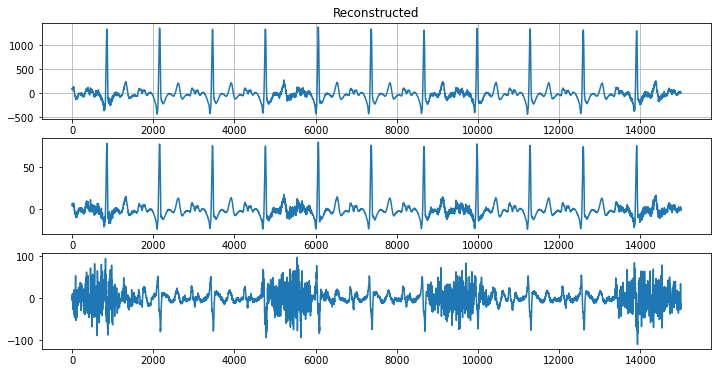

In [34]:
fig, (ax_1,ax_2, ax_3) = plt.subplots(nrows = 3, figsize=(12, 6))
ax_1.grid(True)
ax_1.plot(rec_0[0:15000])
ax_1.set(title='Reconstructed')
ax_2.plot(rec_1[0:15000])
ax_3.plot(rec_2[0:15000])

In [ ]:
fig, (ax_1,ax_2, ax_3) = plt.subplots(nrows = 3, figsize=(12, 6))
ax_1.grid(True)
ax_1.plot(data[0,0:15000])
ax_1.set(title='Original signal')
ax_2.plot(data[1,0:15000])
ax_3.plot(data[2,0:15000])

## We can also do an experiment where we zero evrything that is not the diaphragm sign

But let's write a function that captures all this.

In [ ]:
fig, (ax_1,ax_2, ax_3) = plt.subplots(nrows = 3, figsize=(12, 6))
ax_1.grid(True)
ax_1.plot(data[0,0:15000])
ax_1.set(title='SHould be original signal')
ax_2.plot(data[1,0:15000])
ax_3.plot(data[2,0:15000])

In [ ]:

# def pick_highest_correlation_array(components_data, hi_lead):
    
#     component_list = []
#     num_list = list(range(components_data.shape[0]))
#     for num in num_list:
#         component_list.append(components_data[num])
#     # create a listcontaining the data, each row is a variable,
#     # each column is an observation

#     corr_tuple = np.row_stack((hi_lead, component_list))

#     # compute the correlation matrix
#     corr_matrix = abs(np.corrcoef(corr_tuple))

#     # get the component with the highest correlation to ECG
#     highest_index = np.argmax(corr_matrix[0][1:])
#     desired_component = component_list[highest_index]
#     #return corr_tuple
#     return desired_component, highest_index



In [66]:
data

array([[100.59430237,  93.09736065,  84.67605299, ..., -84.50277032,
        -83.18829034, -81.00957549],
       [  9.60695363,  11.69696697,  11.95682668, ...,  -3.75915911,
         -3.90924103,  -4.24173631],
       [  5.32449486,  -1.55707358,  -5.73269573, ...,   1.90269855,
          1.48953619,   0.54919859]])

In [67]:
#pick_highest_correlation_array(data, data[0])

array([[100.59430237,  93.09736065,  84.67605299, ..., -84.50277032,
        -83.18829034, -81.00957549],
       [  9.60695363,  11.69696697,  11.95682668, ...,  -3.75915911,
         -3.90924103,  -4.24173631],
       [  5.32449486,  -1.55707358,  -5.73269573, ...,   1.90269855,
          1.48953619,   0.54919859]])

In [58]:
# list_to_flip = []
# stack_height = data.shape[0]
# for n in list(range(stack_height)):
#     list_to_flip.append(data[n])
# list_to_flip    

[array([100.59430237,  93.09736065,  84.67605299, ..., -84.50277032,
        -83.18829034, -81.00957549]),
 array([ 9.60695363, 11.69696697, 11.95682668, ..., -3.75915911,
        -3.90924103, -4.24173631]),
 array([ 5.32449486, -1.55707358, -5.73269573, ...,  1.90269855,
         1.48953619,  0.54919859])]

In [63]:
data[0], data[1], data[2]

(array([100.59430237,  93.09736065,  84.67605299, ..., -84.50277032,
        -83.18829034, -81.00957549]),
 array([ 9.60695363, 11.69696697, 11.95682668, ..., -3.75915911,
        -3.90924103, -4.24173631]),
 array([ 5.32449486, -1.55707358, -5.73269573, ...,  1.90269855,
         1.48953619,  0.54919859]))

In [80]:
def reco_ica(data, lead_to_pull_number):
    stack_height = data.shape[0]
    list_to_flip = []
    stack_height = data.shape[0]
    for n in list(range(stack_height)):
        list_to_flip.append(data[n])
    print(list_to_flip)
    X = np.c_[list_to_flip[0],list_to_flip[2],list_to_flip[2]]
    #print(X)
    ica = FastICA(n_components=stack_height)
    print(stack_height)
    S = ica.fit_transform(X)
    Chere = S
    component_0 = S.T[0]
    #component_0 = S.T[0]
    component_1 = S.T[1]
    component_2 = S.T[2]
    matrix_lead_to_pull = hf.pick_highest_correlation_array(data, data[lead_to_pull_number])
    #print(matrix_lead_to_pull)
    matrix_lead_to_pull_number =  matrix_lead_to_pull[1] 
    #print(matrix_lead_to_pull_number)
    #
    #S.T[matrix_lead_to_pull_number] = np.zeros(len(component_0))
    S.T[2] = np.zeros(len(component_2))
    #reconstructed = ica.inverse_transform(S)
    reconstructed = ica.inverse_transform(S)
    #print(reconstructed)
    rec_0 = reconstructed[0,:]
    rec_1 = reconstructed[1,:]
    rec_2 = reconstructed[2,:]
    #rematrix = np.stack(rec_0,rec_1,rec_2)
    #return rec_0, rec_1, rec_2
    return Chere
    

In [81]:
reco_ica(data, 0)

[array([100.59430237,  93.09736065,  84.67605299, ..., -84.50277032,
       -83.18829034, -81.00957549]), array([ 9.60695363, 11.69696697, 11.95682668, ..., -3.75915911,
       -3.90924103, -4.24173631]), array([ 5.32449486, -1.55707358, -5.73269573, ...,  1.90269855,
        1.48953619,  0.54919859])]
3


C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


array([[ 0.00116837, -0.00116801,  0.        ],
       [ 0.00019907, -0.00020219,  0.        ],
       [-0.00041123,  0.00040087,  0.        ],
       ...,
       [-0.00011167,  0.00011547,  0.        ],
       [-0.00016579,  0.00016568,  0.        ],
       [-0.00028237,  0.00028341,  0.        ]])

In [82]:
C

array([[ 1.08068056e-03,  1.16482800e-03,  8.13383710e-04],
       [ 9.83482116e-04,  2.47608448e-04,  1.55621590e-03],
       [ 8.86906997e-04, -3.34110155e-04,  1.81463063e-03],
       ...,
       [-9.36007876e-04, -7.55039312e-05,  2.68426425e-04],
       [-9.20065905e-04, -1.27938199e-04,  2.19409046e-04],
       [-8.93071249e-04, -2.49906344e-04,  1.21912102e-04]])

In [41]:
rec_0,rec_1,rec_2 = reco_ica(data, 0)

[[100.59430237  93.09736065  84.67605299 ... -84.50277032 -83.18829034
  -81.00957549]
 [  9.60695363  11.69696697  11.95682668 ...  -3.75915911  -3.90924103
   -4.24173631]
 [  5.32449486  -1.55707358  -5.73269573 ...   1.90269855   1.48953619
    0.54919859]]
(array([100.59430237,  93.09736065,  84.67605299, ..., -84.50277032,
       -83.18829034, -81.00957549]), 0)
0
[[ 38.50858362  34.41241801  30.30006131 ... -28.78641029 -28.53599839
  -28.23403773]
 [ 38.50858362  34.41241801  30.30006131 ... -28.78641029 -28.53599839
  -28.23403773]
 [ 38.50858362  34.41241801  30.30006131 ... -28.78641029 -28.53599839
  -28.23403773]]


C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [42]:
rec_0

array([ 38.50858362,  34.41241801,  30.30006131, ..., -28.78641029,
       -28.53599839, -28.23403773])

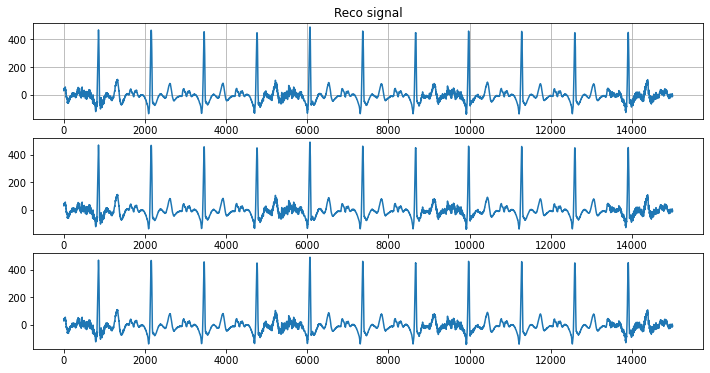

In [45]:
fig, (ax_1,ax_2, ax_3) = plt.subplots(nrows = 3, figsize=(12, 6))
ax_1.grid(True)
ax_1.plot(rec_0[0:15000])
ax_1.set(title='Reco signal')
ax_2.plot(rec_1[0:15000])
ax_3.plot(rec_2[0:15000])